In [1]:
# import necessary libraries
import pandas as pd
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# load the necessary files
filteredMatchDetails = pd.read_csv('../dataset/filteredMatchDetails.csv')
assistsMapDF = pd.read_csv('../dataset/assistsMap.csv', header=0)

In [3]:
filteredMatchDetails.columns

Index(['gameId', 'gameDuration', 'puuid', 'summonerId', 'teamId', 'win',
       'teamPosition', 'champExperience', 'kills', 'assists', 'turretKills',
       'epicMonsterKills', 'visionScore', 'visionWardsBoughtInGame',
       'magicDamageDealtToChampions', 'deaths', 'totalMinionsKilled',
       'timeCCingOthers', 'totalDamageTaken', 'totalHealsOnTeammates',
       'totalTimeSpentDead', 'goldEarned', 'objectivesStolen',
       'objectivesStolenAssists', 'participantId', 'participantsAssisted',
       'towerKillsAssisted', 'monsterKillsAssisted',
       'participantsAssistedWithPressure', 'queueType', 'tier', 'rank',
       'leaguePoints', 'matchPlayerCounts', 'summonerGamesPlayed', 'tierRank',
       'playerNumericalRank', 'matchAverageRank', 'teamAverageRank',
       'totalTeamGold', 'totalTeamGPM', 'totalTeamKills', 'totalTeamKPM',
       'totalTeamDeaths', 'totalTeamAssists', 'totalTeamAPM',
       'totalTeamEpicMonsterKills', 'totalTeamTurretKills',
       'totalTeamVisionScore', 't

In [4]:
playerIndegreeAndOutDegree = assistsMapDF[['gameId', 'teamId', 'teamPosition', 'playerTotalIndegree', 'playerTotalOutdegree']]
filteredMatchDetails = filteredMatchDetails.merge(playerIndegreeAndOutDegree, on=['gameId', 'teamId', 'teamPosition'], how='left')
filteredMatchDetails['playerTotalIndegree'].fillna(0, inplace=True)
filteredMatchDetails['playerTotalOutdegree'].fillna(0, inplace=True)

filteredMatchDetails['playerGoldPerMin'] = filteredMatchDetails['goldEarned'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerExpPerMin'] = filteredMatchDetails['champExperience'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerAssistsPerMin'] = filteredMatchDetails['assists'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerVisionScorePerMin'] = filteredMatchDetails['visionScore'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['playerMinionsKilledPerMin'] = filteredMatchDetails['totalMinionsKilled'] / filteredMatchDetails['gameDuration']
filteredMatchDetails['intensity'] = filteredMatchDetails['assists'] / filteredMatchDetails['kills']

/tmp/ipykernel_52299/882792970.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filteredMatchDetails['playerTotalIndegree'].fillna(0, inplace=True)
/tmp/ipykernel_52299/882792970.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

## Perform variance inflation test and correlation test on set of features

In [5]:
# perform correlation tests
from patsy import dmatrices
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# using original set of metrics before, we had share of the match
playerPerformance_features = filteredMatchDetails[[   
                        'playerNumericalRank', 'goldEarned', 'playerGoldPerMin', 'champExperience', 'playerExpPerMin',
                        'kills', 'deaths', 'assists', 'playerAssistsPerMin', 'turretKills', 'epicMonsterKills',
                        'visionScore', 'playerVisionScorePerMin', 'totalMinionsKilled', 'playerMinionsKilledPerMin', 'playerTotalIndegree',
                        'playerTotalOutdegree'
                        ]]

correlation_matrix = playerPerformance_features.corr()

# Function to calculate p-values
def correlation_test(x, y):
    return stats.pearsonr(x, y)

# Calculating p-values
p_values = pd.DataFrame(index=playerPerformance_features.columns, columns=playerPerformance_features.columns)

for col1 in playerPerformance_features.columns:
    for col2 in playerPerformance_features.columns:
        if col1 == col2:
            p_values[col1][col2] = np.nan  # NaN for the diagonal
        else:
            corr_test = correlation_test(playerPerformance_features[col1], playerPerformance_features[col2])
            p_values[col1][col2] = corr_test[1]  # Extract the p-value

# print(p_values)

print("Correlation Matrix:")

correlation_matrix


/tmp/ipykernel_52299/3564625211.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  p_values[col1][col2] = np.nan  # NaN for the diagonal
/tmp/ipykernel_52299/3564625211.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in

Correlation Matrix:


,playerNumericalRank,goldEarned,playerGoldPerMin,champExperience,playerExpPerMin,kills,deaths,assists,playerAssistsPerMin,turretKills,epicMonsterKills,visionScore,playerVisionScorePerMin,totalMinionsKilled,playerMinionsKilledPerMin,playerTotalIndegree,playerTotalOutdegree
playerNumericalRank,1.000000,-0.039009,0.137427,-0.104723,0.059868,-0.036443,-0.104283,0.035496,0.106178,0.003318,-0.008927,0.060714,0.117380,0.042501,0.103909,-0.114892,-0.047101
goldEarned,-0.039009,1.000000,0.751818,0.880900,0.673466,0.780561,0.103216,0.100005,-0.069594,0.477597,0.250985,-0.166079,-0.319624,0.512574,0.336969,0.678684,0.186209
playerGoldPerMin,0.137427,0.751818,1.000000,0.510417,0.773290,0.787870,-0.210474,-0.143525,-0.137607,0.550587,0.223778,-0.430221,-0.453240,0.470069,0.479787,0.620401,-0.071663
champExperience,-0.104723,0.880900,0.510417,1.000000,0.750070,0.537470,0.096709,0.161838,-0.043838,0.378108,0.234972,-0.108420,-0.288863,0.495966,0.297857,0.475460,0.242280
playerExpPerMin,0.059868,0.673466,0.773290,0.750070,1.000000,0.534849,-0.250949,-0.089116,-0.131783,0.476130,0.228091,-0.416900,-0.479398,0.517489,0.497316,0.405334,-0.016073
kills,-0.036443,0.780561,0.787870,0.537470,0.534849,1.000000,0.005430,-0.038217,-0.105669,0.337943,0.219727,-0.220226,-0.286771,0.291152,0.217371,0.800016,0.042369
deaths,-0.104283,0.103216,-0.210474,0.096709,-0.250949,0.005430,1.000000,0.018121,-0.104622,-0.158212,-0.088532,0.056949,-0.035007,-0.000569,-0.106271,-0.033831,0.000240
assists,0.035496,0.100005,-0.143525,0.161838,-0.089116,-0.038217,0.018121,1.000000,0.946947,-0.069826,0.099493,0.552628,0.493111,-0.321834,-0.415997,0.071574,0.881712
playerAssistsPerMin,0.106178,-0.069594,-0.137607,-0.043838,-0.131783,-0.105669,-0.104622,0.946947,1.000000,-0.087808,0.073266,0.493633,0.511422,-0.397103,-0.430775,-0.002654,0.811472
turretKills,0.003318,0.477597,0.550587,0.378108,0.476130,0.337943,-0.158212,-0.069826,-0.087808,1.000000,-0.032136,-0.204990,-0.233793,0.442530,0.419974,0.292122,0.009008


### VIF on player performance features

In [6]:
# Perform VIF test on player performance features
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

# Add a constant for the intercept
X = sm.add_constant(playerPerformance_features)

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data['features'] = playerPerformance_features.columns
vif_data['VIF'] = [ variance_inflation_factor(playerPerformance_features.values, i) for i in range(playerPerformance_features.shape[1]) ]

print(vif_data)

                     features          VIF
0         playerNumericalRank     5.827782
1                  goldEarned  2201.201440
2            playerGoldPerMin  1960.244490
3             champExperience  2165.384475
4             playerExpPerMin  2027.866412
5                       kills    15.953166
6                      deaths     6.123098
7                     assists   206.750915
8         playerAssistsPerMin   186.521278
9                 turretKills     2.731269
10           epicMonsterKills     3.058415
11                visionScore   127.176390
12    playerVisionScorePerMin   126.427492
13         totalMinionsKilled   222.123769
14  playerMinionsKilledPerMin   205.781131
15        playerTotalIndegree     9.294299
16       playerTotalOutdegree    19.981659


### Features set used -- `'playerExpPerMin', 'playerVisionScorePerMin', 'playerTotalIndegree', 'playerTotalOutdegree', 'turretKills', 'epicMonsterKills'`

In [7]:
# VIF on selective set of columns removing gold earned related columns
features_subset = playerPerformance_features[['playerExpPerMin', 'playerVisionScorePerMin', 'playerTotalIndegree', 'playerTotalOutdegree', 'playerGoldPerMin', 'playerNumericalRank']]

X = sm.add_constant(features_subset)

vif_data_v2 = pd.DataFrame()
vif_data_v2['features'] = features_subset.columns
vif_data_v2['VIF'] = [ variance_inflation_factor(features_subset.values, i) for i in range(features_subset.shape[1]) ] 

print(vif_data_v2)  

                  features        VIF
0          playerExpPerMin  71.265635
1  playerVisionScorePerMin   3.698296
2      playerTotalIndegree   4.375317
3     playerTotalOutdegree   5.512292
4         playerGoldPerMin  86.296354
5      playerNumericalRank   5.403321


### Scree analysis to detect number of factors

In [8]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

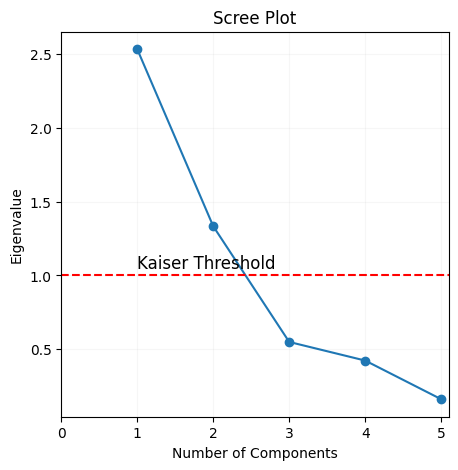

In [9]:
# scale features
features = playerPerformance_features[['playerExpPerMin', 'playerVisionScorePerMin', 'playerTotalIndegree', 'playerTotalOutdegree', 'playerGoldPerMin']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca.fit(features_scaled)


# Plot the Scree Plot
plt.figure(figsize=(5,5))
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.axhline(y=1, color='r', linestyle='--')
plt.text(1, 1.05, 'Kaiser Threshold', color='black', fontsize=12)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.grid(axis='both', alpha=0.1)
plt.xlim(0, 5.1)
plt.show()

### KMO test to check for suitability of Factor analysis

In [10]:
# performing KMO test on the dataset to see if dataframe is suitable for factor analysis
from factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(features_scaled)

# Print the results
print(f"KMO Overall: {kmo_model:.4f}")

# If you want to see individual KMO values for each variable:
print("Individual KMO values:\n", kmo_all)

KMO Overall: 0.5788
Individual KMO values:
 [0.60269049 0.6699652  0.57565195 0.33752071 0.59274778]


### KMO Value of 0.57 is not good; but acceptable for factor analysis

In [11]:
# Perform Factor Analysis
fa = FactorAnalysis(n_components=2, rotation='varimax', max_iter=2000)  # Adjust n_components based on Scree Plot; making the number of components as 2, because we dont see a good distinction of features with 3 latent factors
fa.fit(features_scaled)
factor_loadings = fa.components_.T

# factor loadings for each feature column
loadings_df = pd.DataFrame(factor_loadings, index=features.columns, columns=[f'Factor{i+1}' for i in range(factor_loadings.shape[1])])

# compute factor scores
factor_scores = fa.transform(features_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])])

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/decomposition/_factor_analysis.py:299: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


### Using only 5 features, i.e. player gold per min instead of epic monster kills and turret takedowns, yields a better separation of factor and much more explanatory

In [12]:
loadings_df.rename(columns={'Factor1': 'GiverFactor', 'Factor2': 'ReceiverFactor'}, inplace=True)
loadings_df

,GiverFactor,ReceiverFactor
playerExpPerMin,-0.015595,0.781160
playerVisionScorePerMin,0.420447,-0.434791
playerTotalIndegree,0.188794,0.637975
playerTotalOutdegree,0.993737,-0.002662
playerGoldPerMin,-0.069407,0.988248


In [13]:
# rename columns for better understanding
factor_scores_df.rename(columns={'Factor1': 'GiverFactor', 'Factor2': 'ReceiverFactor'}, inplace=True)
factor_scores_df

,GiverFactor,ReceiverFactor
0,0.161512,-0.618084
1,0.527850,-0.131018
2,-0.077783,0.725236
3,-0.815377,0.362115
4,0.164429,-1.768613
...,...,...
227730,-1.438412,-1.017463
227731,-1.673816,-0.741805
227732,-1.314176,-1.592472
227733,-1.437734,-0.838333


# Fitting and Prediction Using Individual Level Game Metrics

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [10]:
# splitting games into train-test split; 
# we use an additional filter at the top to ensure that both train-test have same number number of win outcomes, sampling equally!
individualDF = individualAllMetrics[['teamId', 'gameId', 'participantId', 'teamPosition', 'win', 'playersMatchTurretShare','champExpPerMin','visionScorePerMin','playersMatchMinionsShare','playerTotalIndegree','playerTotalOutdegree']]


game_ids = individualDF['gameId'].unique()
train_games, test_games = train_test_split(game_ids, test_size=0.2, random_state=176)

train_df = individualDF[individualDF['gameId'].isin(train_games)]
test_df = individualDF[individualDF['gameId'].isin(test_games)]

X_train = train_df[['playersMatchTurretShare','champExpPerMin','visionScorePerMin','playersMatchMinionsShare','playerTotalIndegree','playerTotalOutdegree']]
y_train = train_df['win']

X_test = test_df[['playersMatchTurretShare','champExpPerMin','visionScorePerMin','playersMatchMinionsShare','playerTotalIndegree','playerTotalOutdegree']]
y_test = test_df['win']

features_names = X_train.columns

### Binary Logistic Regression

In [11]:
# check for results with and without scaling
# Scaling data features to avoid model skewing; performing scaling may not be necessary, because we have transformed the data!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [12]:
# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))

y_pred = model.predict(X_test)

In [ ]:
# p-values using statsmodels
import statsmodels.api as sm
X = sm.add_constant(X_train) # adding a constant intercept term
logit_model = sm.Logit(y_train, X).fit()
print(logit_model.summary())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train, y_train)
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

# Dimensionality Reduction - Using Scree and Factor Analysis

In [19]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# scale features
features = individualDF[['playersMatchTurretShare','champExpPerMin','visionScorePerMin','playersMatchMinionsShare','playerTotalIndegree','playerTotalOutdegree']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA()
pca.fit(features_scaled)


# Plot the Scree Plot
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### Results from Scree plot suggests that the number of latent components to be 2, since eigen value falls below value 1 after 2 components

In [ ]:
# performing KMO test on the dataset to see if dataframe is suitable for factor analysis
from factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(features_scaled)

# Print the results
print(f"KMO Overall: {kmo_model:.4f}")

# If you want to see individual KMO values for each variable:
print("Individual KMO values:\n", kmo_all)

### On account of the result values of KMO Test, I further reduced the number of initial 9 features taken during VIF test, so that KMO > 0.6 is a good fit

In [22]:
# Perform Factor Analysis
fa = FactorAnalysis(n_components=2, rotation='varimax')  # Adjust n_components based on Scree Plot; making the number of components as 2, because we dont see a good distinction of features with 3 latent factors
fa.fit(features_scaled)
factor_loadings = fa.components_.T

# factor loadings for each feature column
loadings_df = pd.DataFrame(factor_loadings, index=features.columns, columns=[f'Factor{i+1}' for i in range(factor_loadings.shape[1])])

# compute factor scores
factor_scores = fa.transform(features_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])])

In [ ]:
loadings_df

In [ ]:
# Use BLR on computed factor scores
y = individualDF['win']
X = factor_scores_df

print(X.shape)
print(y.shape)

# splitting games into train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train, y_train) # use X_train_scaled to fit instead

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))

y_pred = model.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

In [ ]:
# decision tree classifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train, y_train)
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

In [ ]:
# random forest classifier

rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train, y_train)
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

In [ ]:
# XG Boost Classifier

xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

### Interesting point here, is that because we are deriving winning outcomes based on individual performance; the relative importance by all methods for recieving factor (Factor1) has higher importance than the giving factor (Factor2)

In [ ]:
factor_scores_df

In [ ]:
individualSubsetDF = individualDF[['teamId', 'gameId', 'participantId', 'teamPosition', 'win']]
factor_scores_with_individuals = pd.concat([individualSubsetDF, factor_scores_df], axis=1)

factor_scores_with_individuals

### Identifying the number of clusters using Elbow method, Silhouette Score and Davies-Bouldin Score

In [ ]:
## Using the Elbow method
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_scores = []
db_scores = []

inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=12, n_init=10, max_iter=16)
    labels = kmeans.fit_predict(factor_scores_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(factor_scores_df, labels))
    db_scores.append(davies_bouldin_score(factor_scores_df, labels))

# plotting the elbow curve
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Plotting the Silhouette scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

# Plotting the Davies-Bouldin scores
plt.plot(K, db_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method')
plt.show()

## Use knee locator to identify the elbow point if the graph visually doesn't make sense
kl = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print(kl.elbow)

In [ ]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, max_iter=16)
kmeans.fit(factor_scores_df)

factor_scores_with_individuals['inidividual_labels'] = kmeans.labels_

factor_scores_with_individuals

In [ ]:
def labelTeam(team_type):
    if team_type == 0:
        return 'Alpha'
    elif team_type == 1:
        return 'Beta'
    elif team_type == 2:
        return 'Gamma'
    else:
        return 'Delta'
    
factor_scores_with_individuals['individual_class'] = factor_scores_with_individuals['inidividual_labels'].apply(labelTeam)
factor_scores_with_individuals

In [ ]:
individual_groupings = factor_scores_with_individuals[['gameId', 'teamId', 'participantId', 'win', 'individual_class']]
individual_groupings.rename(columns={'win': 'individual_win'}, inplace=True)

individual_groupings

In [ ]:
# join the indvidual groupings df with team groupings df
team_groupings = pd.read_csv('./team_groupings.csv')
team_groupings

In [ ]:
individual_with_team_groupings = individual_groupings.merge(team_groupings, on=['gameId', 'teamId'], how='inner')
individual_with_team_groupings['sanity_check'] = individual_with_team_groupings['individual_win'] == individual_with_team_groupings['team_win']
individual_with_team_groupings

In [ ]:
individual_with_team_groupings['sanity_check'].value_counts()